In [1]:
import numpy as np 
import pandas as pd
import os
import time
import matplotlib.pyplot as plt

from glob import glob

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from itertools import chain
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import VGG19
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras import optimizers, callbacks, regularizers

%matplotlib inline

Using TensorFlow backend.


In [2]:
all_xray_df = pd.read_csv('../data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'data', 'images*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]

all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

# since the dataset is very unbiased, we can resample it to be a more reasonable collection

Scans found: 112120 , Total Headers 112120
All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


In [3]:
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(40000, weights=sample_weights)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]

label_counts = 100*np.mean(all_xray_df[all_labels].values,0)

# Prepare Training Data
Here we split the data into training and validation sets and create a single vector (disease_vec) with the 0/1 outputs for the disease status (what the model will try and predict)

In [4]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [5]:
train_df, valid_df = train_test_split(all_xray_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 30000 validation 10000


# Create Data Generators
Here we make the data generators for loading and randomly transforming images

In [6]:
valid_df['newLabel'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [7]:
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [8]:
def MakeMobileNetModel(IMG_SIZE, bs, channels=1):
    model = Sequential()
    base_model = MobileNet(input_shape =  (*IMG_SIZE, channels), #Need to define the shape here from IMG_SIZE
                                 include_top = False, weights = None)
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(len(all_labels), activation = 'sigmoid'))
    return model

# Create Models and Load Weights

## Define Parameters

In [9]:
imageSize = (512, 512)
colorMode = 'rgb'
channels = 3
batchSize = 16

valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df, 
                         directory=None,
                         x_col = 'path',
                        y_col = 'newLabel', 
                         class_mode = 'categorical',
                        classes = all_labels,
                        target_size = imageSize,
                         color_mode = colorMode,
                        batch_size = batchSize,
                        seed=1234) 

Found 9423 images belonging to 13 classes.


In [10]:
def createROC(all_labels, test_Y, pred_Y):
    aucScores = []
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    for (idx, c_label) in enumerate(all_labels):
        fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
        aucScores.append(auc(fpr,tpr))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

    return aucScores

## MobileNet

In [11]:
mobilenet_model = MakeMobileNetModel(imageSize, batchSize, channels)
mobilenet_model.load_weights('xray_class_weights.best.hdf5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
# Generate Predictions and Get Y Labels
start = time.time()
predictions = []
y_labels = []

for i in range(valid_gen.__len__()):
    if(i%10==0):
        print("Predicting batch:", i)
    x, y = next(valid_gen)
    predictions.append(mobilenet_model.predict(x))
    y_labels.append(y)

end = time.time()
duration = end - start
print("Prediction Took {:.2} minutes".format(duration/60))

Predicting batch: 0
Predicting batch: 10
Predicting batch: 20
Predicting batch: 30
Predicting batch: 40
Predicting batch: 50
Predicting batch: 60
Predicting batch: 70
Predicting batch: 80
Predicting batch: 90
Predicting batch: 100
Predicting batch: 110
Predicting batch: 120
Predicting batch: 130
Predicting batch: 140
Predicting batch: 150
Predicting batch: 160
Predicting batch: 170
Predicting batch: 180
Predicting batch: 190
Predicting batch: 200
Predicting batch: 210
Predicting batch: 220
Predicting batch: 230
Predicting batch: 240
Predicting batch: 250
Predicting batch: 260
Predicting batch: 270
Predicting batch: 280
Predicting batch: 290
Predicting batch: 300
Predicting batch: 310
Predicting batch: 320
Predicting batch: 330
Predicting batch: 340
Predicting batch: 350
Predicting batch: 360
Predicting batch: 370
Predicting batch: 380
Predicting batch: 390
Predicting batch: 400
Predicting batch: 410
Predicting batch: 420
Predicting batch: 430
Predicting batch: 440
Predicting batch: 450

In [13]:
test_Y = np.concatenate(y_labels)

In [14]:
mobilenet_preds = np.concatenate(predictions)

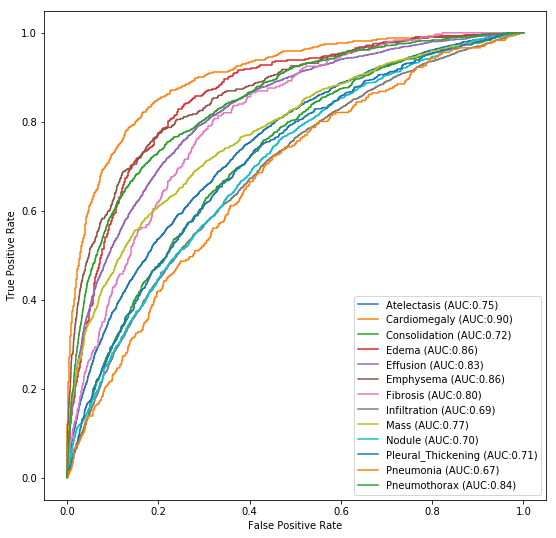

In [15]:
mobilenetAUC = createROC(all_labels, test_Y, mobilenet_preds)

In [16]:
summaryDF = pd.DataFrame(
    {'Class':all_labels,
    'Mobilenet': mobilenetAUC,
    }
)

In [17]:
print("Summary ROC Scores of Mobile Net Inference")
print(summaryDF.round(3))

Summary ROC Scores of Mobile Net Inference
                 Class  Mobilenet
0          Atelectasis      0.745
1         Cardiomegaly      0.903
2        Consolidation      0.718
3                Edema      0.859
4             Effusion      0.825
5            Emphysema      0.862
6             Fibrosis      0.804
7         Infiltration      0.686
8                 Mass      0.774
9               Nodule      0.698
10  Pleural_Thickening      0.713
11           Pneumonia      0.671
12        Pneumothorax      0.845


In [18]:
print("Results Saved to CSV")
summaryDF.to_csv("mobilenetInferenceDF.csv", index=False)

Results Saved to CSV
